## Load libraries

In [63]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data

# Libraries to cluster data
from gensim.corpora import Dictionary
from gensim.models import HdpModel
from sklearn.mixture import BayesianGaussianMixture as BGM

# Libraries to visualize data
import matplotlib.pyplot as plt
from pprint import pprint
from cluster_visualization_helper import visualize_cluster, compute_cluster_visualization  # user-defined functions

# Libraries for evaluation
import tmtoolkit
from gensim.models import CoherenceModel

# Libraries for monitoring operation process
from tqdm import tqdm

## Configurate and declare global variables

In [51]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

## Import data

In [52]:
title_docs = pd.read_csv(OUTPUT_DIR + "title_docs.csv")

## Convert data to correct type

In [53]:
title_docs["clean_job_title"] = title_docs["clean_job_title"].apply(ast.literal_eval)

In [54]:
title_docs["clean_job_title"]

0                              [chief, financial, officer]
1        [full, time, community, connection, intern, pa...
2                                   [country, coordinator]
3                                        [bcc, specialist]
4                                    [software, developer]
                               ...                        
18987                 [senior, creative, ux, ui, designer]
18988                     [category, development, manager]
18989                    [operational, marketing, manager]
18990                     [head, online, sale, department]
18991                          [lawyer, legal, department]
Name: clean_job_title, Length: 18992, dtype: object

## Clustering data

### Hierarchical Dirichlet Process (HDP) 

In [56]:
# Create doc list of clean job titles
doc_list = [
    " ".join(doc) for doc in title_docs["clean_job_title"].values.tolist()
]
pprint(doc_list[:10])

# Create corpus (list of tokens per document)
title_corpus = title_docs["clean_job_title"].values.tolist()
pprint(title_corpus[:10])

# Create Dictionary
id2word = Dictionary(title_corpus)

# Term Document Frequency
hdp_corpus = [id2word.doc2bow(text) for text in title_corpus]
pprint(hdp_corpus[:3])

['chief financial officer',
 'full time community connection intern pay internship',
 'country coordinator',
 'bcc specialist',
 'software developer',
 'saleswoman',
 'chief accountant finance assistant',
 'non pay part full time programmatic intern',
 'assistant manage director',
 'program assistant inl fsn fp']
[['chief', 'financial', 'officer'],
 ['full', 'time', 'community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 ['bcc', 'specialist'],
 ['software', 'developer'],
 ['saleswoman'],
 ['chief', 'accountant', 'finance', 'assistant'],
 ['non', 'pay', 'part', 'full', 'time', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant', 'inl', 'fsn', 'fp']]
[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1), (11, 1)]]


In [57]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in hdp_corpus[:3]]

[[('chief', 1), ('financial', 1), ('officer', 1)],
 [('community', 1),
  ('connection', 1),
  ('full', 1),
  ('intern', 1),
  ('internship', 1),
  ('pay', 1),
  ('time', 1)],
 [('coordinator', 1), ('country', 1)]]

In [150]:
def build_hdp_model(dictionary, corpus, a, b, T=300):
    """
    Build Hierarchical Dirichlet Process model

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    a: Dirichlet hyperparameter alpha (Document-Topic Density)
    b: Dirichlet hyperparameter beta (Word-Topic Density)

    Returns:
    -------
    model: LDA topic models
    """

    model = HdpModel(
        corpus=corpus,
        id2word=dictionary,
        random_state=SEED,
#         passes=10,
        alpha=a,
        eta=b, 
        T=T
#         iterations=100
    )

    return model

In [151]:
def compute_evaluation_metrics(model, corpus, dictionary, texts):
    """
    Compute covariance coherence for various number of topics

    Parameters:
    ----------
    model: HDP model
    corpus: Gensim corpus
    dictionary: Gensim dictionary
    texts: List of input texts

    Returns:
    -------
    coherence_value: Coherence value corresponding to the LDA model with respective number of topics
    perplexity_value: Perplexity value corresponding to the LDA model with respective number of topics
    """

    coherencemodel = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence="c_v"
    )

    coherence_value = coherencemodel.get_coherence()

    return coherence_value

In [152]:
# Alpha parameter
alpha = list(np.arange(1, 3, 1))

# Beta parameter
beta = list(np.arange(0.01, 2, 0.5))

model_results = {
    "Alpha_num": [],
    "Alpha": [],
    "Beta_num": [],
    "Beta": [],
    "Coherence": []
}

In [153]:
# len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)

In [96]:
# Tuning LDA to find optimal number of topics
pbar = tqdm(
    desc="HDP tuning",
    total=len(alpha) * len(beta)
)

# iterate through alpha values
for ida, a in enumerate(alpha):
    # iterare through beta values
    for idb, b in enumerate(beta):
        # get the coherence score for the given parameters
        hdp_model = build_hdp_model(
            dictionary=id2word, corpus=hdp_corpus, a=a, b=b
        )
        coher_score = compute_evaluation_metrics(
            hdp_model,
            corpus=hdp_corpus,
            dictionary=id2word,
            texts=title_corpus
        )

        # Save the model results
        model_results["Alpha_num"].append(ida)
        model_results["Alpha"].append(a)
        model_results["Beta_num"].append(idb)
        model_results["Beta"].append(b)
        model_results["Coherence"].append(coher_score)

        pbar.update(1)

model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv(OUTPUT_DIR + "hdp_tuning_results.csv", index=False)
pbar.close()

HDP tuning: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:25<00:00, 33.18s/it]


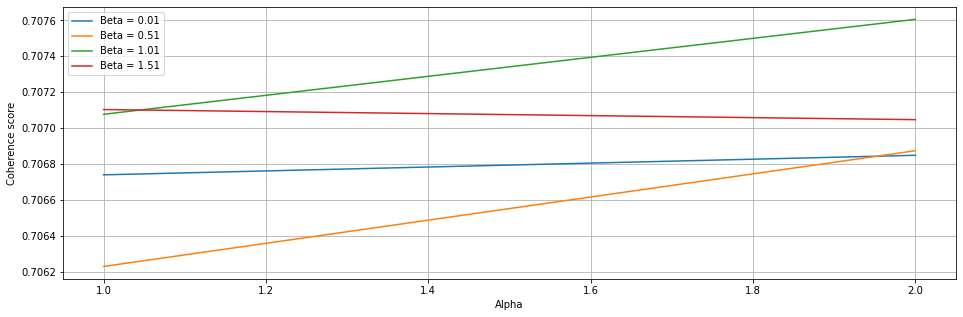

In [97]:
# Draw graph of Coherence values
plt.figure(figsize=(16, 5))
for b in beta:
    plot_df = model_results_df.loc[model_results_df["Beta"] == b]
    plt.plot(
        plot_df["Alpha"],
        plot_df["Coherence"],
        label=f"Beta = {b}"
    )
#     plt.title(f"Beta = {b}")
plt.legend(loc="best")
plt.xlabel("Alpha")
#     plt.xticks(topics_range)
plt.ylabel("Coherence score")
plt.grid()
plt.show()

In [98]:
np.argmax(model_results_df['Coherence'].values), np.max(model_results_df['Coherence'].values)

(6, 0.7076054805787196)

In [99]:
model_results_df.loc[6]

Alpha_num    1.000000
Alpha        2.000000
Beta_num     2.000000
Beta         1.010000
Coherence    0.707605
Name: 6, dtype: float64

In [154]:
# Select the LDA model with optimal number of topics
best_index = np.argmax(model_results_df["Coherence"].values)
# best_num_topics = model_results_df["Topics"].loc[best_index]
best_alpha = model_results_df["Alpha"].loc[best_index]
best_beta = model_results_df["Beta"].loc[best_index]

print(
    f"Best alpha = {best_alpha}, best beta = {best_beta}"
)
best_hdp_model = build_hdp_model(
    dictionary=id2word, corpus=hdp_corpus, a=best_alpha, b=best_beta
)

Best alpha = 2, best beta = 1.01


In [155]:
best_hdp_model.get_topics().shape

(300, 2617)

In [156]:
best_hdp_model.hdp_to_lda()[0]

array([0.0068185 , 0.0069667 , 0.00663107, 0.00670575, 0.00672642,
       0.00682988, 0.00697617, 0.00654716, 0.00657708, 0.00643862,
       0.00663818, 0.0066853 , 0.00666819, 0.0067277 , 0.00699138,
       0.00707039, 0.00675765, 0.00664941, 0.00680009, 0.00673462,
       0.00666529, 0.00666499, 0.00669927, 0.00683709, 0.00661017,
       0.00650407, 0.00683835, 0.00654337, 0.0064671 , 0.00664569,
       0.00675622, 0.00671513, 0.00686323, 0.00666198, 0.0065284 ,
       0.00670269, 0.00669013, 0.00663177, 0.00668336, 0.00651825,
       0.00669252, 0.00658272, 0.00663817, 0.00647197, 0.00678342,
       0.00663281, 0.00656588, 0.00668653, 0.00656292, 0.00691604,
       0.00661501, 0.00665295, 0.00674273, 0.00640132, 0.00648977,
       0.00665055, 0.00666858, 0.00668896, 0.00670019, 0.00689365,
       0.00678268, 0.00677449, 0.00658773, 0.00657081, 0.00660369,
       0.0066466 , 0.00690109, 0.00670603, 0.00655141, 0.00661627,
       0.00685919, 0.0068059 , 0.00679784, 0.00646119, 0.00685

In [157]:
def topic_prob_extractor(hdp_model):
    shown_topics = hdp_model.show_topics(
        num_topics=hdp_model.m_T, formatted=False
    )
    topics_nos = [x[0] for x in shown_topics]
    weights = [
        sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos
    ]
    return pd.DataFrame({"topic_id": topics_nos, "weight": weights})

In [158]:
topic_weights = topic_prob_extractor(best_hdp_model)

In [159]:
topic_weights.shape

(300, 2)

In [160]:
topic_weights

,topic_id,weight
0,0,0.033151
1,1,0.033681
2,2,0.031639
3,3,0.033301
4,4,0.033094
...,...,...
295,295,0.033595
296,296,0.029041
297,297,0.033602
298,298,0.030267


In [161]:
max(topic_weights['weight']), min(topic_weights['weight'])

(0.03618719685792097, 0.029040845521115532)

In [166]:
best_hdp_model.m_T

300

In [168]:
hdp_model.print_topics(num_topics=20, num_words=5)

[(0,
  '0.003*director + 0.002*specialist + 0.002*fleet + 0.002*manager + 0.002*consumer'),
 (1,
  '0.002*upper + 0.002*integrity + 0.002*volunteer + 0.002*layer + 0.002*inventory'),
 (2,
  '0.003*specialist + 0.002*teach + 0.002*developer + 0.002*artist + 0.002*score'),
 (3,
  '0.002*offier + 0.002*backhaul + 0.002*philately + 0.002*accountant + 0.002*domain'),
 (4,
  '0.002*stakeholder + 0.002*funding + 0.002*logistic + 0.002*readiness + 0.002*anthropology'),
 (5,
  '0.002*developer + 0.002*scm + 0.002*software + 0.002*harvest + 0.002*generalist'),
 (6,
  '0.003*distributor + 0.002*several + 0.002*pool + 0.002*gap + 0.002*cleaner'),
 (7,
  '0.003*garage + 0.003*tournament + 0.002*feldsher + 0.002*manual + 0.002*domain'),
 (8,
  '0.002*carfleet + 0.002*fair + 0.002*youth + 0.002*publishing + 0.002*administrator'),
 (9,
  '0.002*ambulatory + 0.002*manager + 0.002*rental + 0.002*ijevan + 0.002*metric'),
 (10,
  '0.003*institutional + 0.002*pump + 0.002*dissemination + 0.002*daily + 0.00

In [169]:
# Reduce dimensionality using t-SNE algorithm
pca_datapoint, tsne_datapoint = compute_cluster_visualization(
    arr, pca=True, tsne=True, seed=SEED
)

Start PCA 2021-04-28 00:53:10.382450
End PCA 2021-04-28 00:53:10.400448
PCA duration 0:00:00.017998
Start t-SNE 2021-04-28 00:53:10.400448
End t-SNE 2021-04-28 00:54:17.869010
t-SNE duration 0:01:07.468562


In [69]:
## Save PCA and t-SNE dimensionality reduced data to file
np.save(OUTPUT_DIR + "hdp_pca_datapoints", pca_datapoint)
np.save(OUTPUT_DIR + "hdp_tsne_datapoints", tsne_datapoint)

Start PCA 2021-04-27 20:55:37.815805
End PCA 2021-04-27 20:55:37.829806
PCA duration 0:00:00.014001

Start t-SNE 2021-04-27 20:55:37.829806
End t-SNE 2021-04-27 20:55:37.833807
t-SNE duration 0:00:00.004001

Wall time: 182 ms


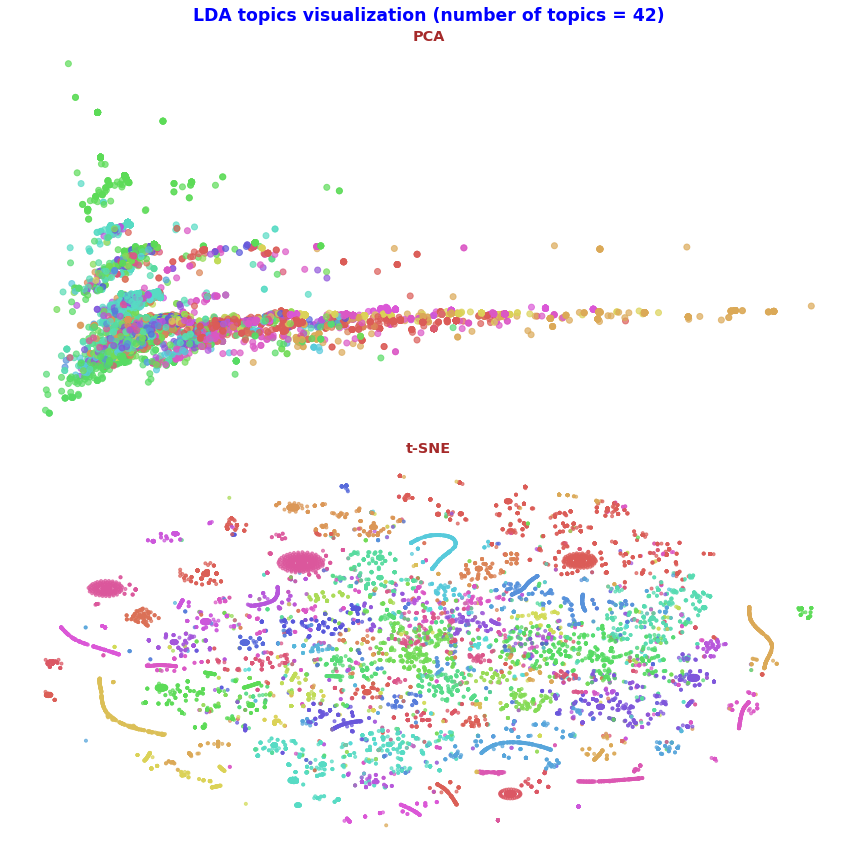

In [70]:
%%time
plot_title = f"LDA topics visualization (number of topics = {best_num_topics})"
palette = sns.color_palette("hls", as_cmap=True)
colors = topic_num / best_num_topics

# Visualize clusters with PCA and t-SNE
visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint, tsne_datapoint, pca=True, tsne=True)

In [147]:
# Finding the dominant topic in each sentence
def format_topics_sentences(hdpmodel=best_hdp_model, corpus=hdp_corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(hdpmodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = hdpmodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(
    hdpmodel=best_hdp_model, corpus=hdp_corpus, texts=doc_list
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,50.0,0.6040,"informational, congress, financial, agent, app...",chief financial officer
1,1,32.0,0.5691,"franchise, developer, school, internship, tick...",full time community connection intern pay inte...
2,2,27.0,0.5050,"aparan, data, mba, participation, aspn, financ...",country coordinator
3,3,60.0,0.5050,"website, cheese, united, advisor, digitization...",bcc specialist
4,4,66.0,0.5050,"developer, risk, coordinatior, concierge, robo...",software developer
5,5,4.0,0.3400,"stakeholder, funding, logistic, readiness, ant...",saleswoman
6,6,87.0,0.6700,"textile, chief, yerevan, ta, link, partner, st...",chief accountant finance assistant
7,7,90.0,0.7800,"deputy, echmiadzin, advocacy, advisor, analyse...",non pay part full time programmatic intern
8,8,90.0,0.6040,"deputy, echmiadzin, advocacy, advisor, analyse...",assistant manage director
9,9,19.0,0.7172,"development, seg, roam, agent, senior, dry, cl...",program assistant inl fsn fp


In [148]:
# Find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat(
        [
            sent_topics_sorted_df,
            grp.sort_values(["Perc_Contribution"], ascending=[0]).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]

# Show
sent_topics_sorted_df.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7525,"upper, integrity, volunteer, layer, inventory,...",intern un resident coordinator unrc unit
1,1.0,0.8350,"director, fleet, specialist, consumer, manager...",young specialist monetary policy department cb...
2,2.0,0.7800,"offier, backhaul, philately, domain, accountan...",head contract legal analysis unit legal depart...
3,3.0,0.7800,"specialist, teach, developer, artist, score, g...",hi tech seminar software process improvement i...
4,4.0,0.7525,"stakeholder, funding, logistic, readiness, ant...",voter list advisory committee vlac coordinator
5,5.0,0.7800,"scm, harvest, developer, software, generalist,...",senior software engineer layout process depart...
6,6.0,0.7171,"garage, tournament, feldsher, domain, manual, ...",economist researcher economic research department
7,7.0,0.7800,"carfleet, fair, youth, publishing, app, admini...",small grant pilot project human right education
8,8.0,0.7525,"window, board, entertainment, vice, macro, od,...",cad librarian print circuit board design
9,9.0,0.8020,"village, doctor, stay, hardware, twin, consult...",retail sale coordinator branch network sale su...


In [149]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords["Dominant_Topic"].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts / topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[["Dominant_Topic", "Topic_Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat(
    [topic_num_keywords, topic_counts, topic_contribution], axis=1
)

# Change Column names
df_dominant_topics.columns = [
    "Dominant_Topic",
    "Topic_Keywords",
    "Num_Documents",
    "Perc_Documents",
]

df_dominant_topics.dropna(subset=['Num_Documents'], inplace=True)
df_dominant_topics.sort_values(by=['Num_Documents'], ascending=False, inplace=True)

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
66.0,13.0,"prip, alaverdi, pub, project, peer, active, bo...",960.0,0.0505
62.0,1.0,"director, fleet, specialist, consumer, manager...",455.0,0.0240
1.0,32.0,"franchise, developer, school, internship, tick...",453.0,0.0239
49.0,52.0,"corporate, patient, confectionery, eastern, pr...",431.0,0.0227
87.0,90.0,"deputy, echmiadzin, advocacy, advisor, analyse...",427.0,0.0225
...,...,...,...,...
17.0,71.0,"aim, rdc, psr, msf, banking, pool, ihl, practi...",59.0,0.0031
78.0,75.0,"advanced, controler, device, litigation, indus...",56.0,0.0029
63.0,1.0,"director, fleet, specialist, consumer, manager...",53.0,0.0028
21.0,49.0,"martuni, lawyer, information, even, department...",47.0,0.0025


In [84]:
pca_datapoint_raw = np.load(OUTPUT_DIR + "pca_datapoints.npy")
tsne_datapoint_raw = np.load(OUTPUT_DIR + "tsne_datapoints.npy")

Start PCA 2021-04-27 21:22:14.842618
End PCA 2021-04-27 21:22:14.845618
PCA duration 0:00:00.003000

Start t-SNE 2021-04-27 21:22:14.845618
End t-SNE 2021-04-27 21:22:14.848619
t-SNE duration 0:00:00.003001

Wall time: 50 ms


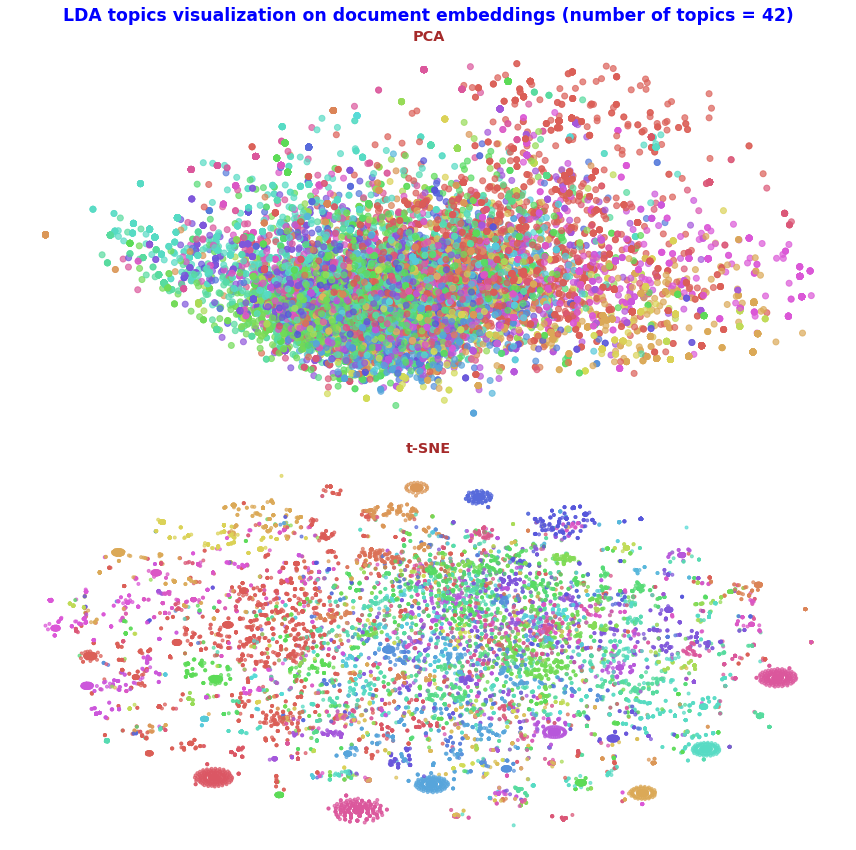

In [87]:
%%time
plot_title = f"LDA topics visualization on document embeddings (number of topics = {best_num_topics})"
palette = sns.color_palette("hls", as_cmap=True)
colors = topic_num / best_num_topics

# Visualize clusters with PCA and t-SNE
visualize_cluster(plot_title, (12,12), colors, palette, pca_datapoint_raw, tsne_datapoint_raw, pca=True, tsne=True)

## Save cluster results to file

In [75]:
df_dominant_topic.to_csv(OUTPUT_DIR + "job-title_dominant-topic_hdp.csv", index=False)

In [76]:
sent_topics_sorted_df.to_csv(
    OUTPUT_DIR + "job-title_represent-doc-per-topic_hdp.csv", index=False
)

In [83]:
df_dominant_topics.to_csv(
    OUTPUT_DIR + "job-title_topic-distribution_hdp.csv", index=False
)